In [4]:
from math import radians
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from numpy.lib import poly
from scipy.spatial import KDTree
from shapely.geometry import Point, LineString, Polygon, box
import random
import pickle as pkl

In [5]:
class Obstacle:
    """
    Class implementing simple 2D polygonal obstacles.

    Attributes
    ----------
    points : list
        List of (x, y) coordinates in the frame of the environnement representing the obstacle.
    bounding_box : 4-tuple
        Coordinates of the lower left and upper right corners of the bounding box containing the obstacle.
    center : tuple
        Coordinates of the center of the bounding box.
    polygon : shapely.geometry.Polygon
        The polygon representing the obstacle.

    Methods
    -------
    plot
        Displays the polygon on screen.

    """

    def __init__(self, map_dimensions, size, shape, nb_pts='5'):
        self.center = np.array(
            [np.random.rand()*map_dimensions[0], np.random.rand()*map_dimensions[1]])
        # Simple convex polygons, generated with a radius and randomly selected angles.
        if shape == 'circle':
            angles = sorted((np.random.rand()*2*np.pi for _ in range(nb_pts)))
        elif shape == 'polygon':
            None

        self.points = \
            np.array([self.center +
                      np.array([size*np.cos(angle), size*np.sin(angle)])
                      for angle in angles])
        self.bounding_box = (min(self.points, key=lambda x: x[0])[0],
                             min(self.points, key=lambda x: x[1])[1],
                             max(self.points, key=lambda x: x[0])[0],
                             max(self.points, key=lambda x: x[1])[1])
        self.polygon = Polygon(self.points)

    def collides(self, x, y):
        """
        Checks if the given point is in the obstacle or not.
        """

        return self.polygon.contains(Point(x, y))

    def plot(self):
        """
        Draws the polygon on screen.
        """

        plt.gca().add_patch(pat.Polygon(self.points, color='blue', fill=True))

In [6]:
class ObstacleMap:
    """
    Class implementing a very simple bounded 2D world, containing polygonal
    obstacles stored in an appropriate data structure for rapid access to close
    obstacles, even with a large amount of them.

    Attributes
    ----------
    dimensions : tuple
        (dim_x, dim_y) The x and y dimension of the rectangular world.
    obstacles : list
        List of obstacles, instances of the obstacle class.
    kdtree : KDTree
        The binary search tree used to have a rapid access to the obstacles, even with a large amount of them.

    Methods
    -------
    plot
        Draws the environnement using matplotlib.
    is_free
        Returns False if a point is within an obstacle or outside of the
        boundaries of the environnement.
    """

    def __init__(self, map_dimensions, obstacle_size, nb_obstacles, shape='circle'):
        self.dimensions = map_dimensions
        self.obstacles = [Obstacle(
            map_dimensions, obstacle_size, shape, nb_pts=5) for _ in range(nb_obstacles)]
        self.kdtree = KDTree([obs.center for obs in self.obstacles])

    def plot(self, close=False, display=True):
        """
        Creates a figure and plots the environement on it.

        Parameters
        ----------
        close : bool
            If the plot needs to be automatically closed after the drawing.
        display : bool
            If the view pops up or not (used when generating many images)
        """

        plt.ion() if display else plt.ioff()
        for obstacle in self.obstacles:
            obstacle.plot()
        plt.gca().set_xlim(0, self.dimensions[0])
        plt.gca().set_ylim(0, self.dimensions[1])
        if close:
            plt.close()

    def is_free(self, x, y, time=0):
        """
        Returns False if a point is within an obstacle or outside of the
        boundaries of the environnement.
        """

        if x < 0 or x > self.dimensions[0]\
                or y < 0 or y > self.dimensions[1]:
            return False
        for obstacle in self.close_obstacles(x, y, nb_obstacles=5):
            if obstacle.colides(x, y):
                return False
        return True

    def close_obstacles(self, x, y, nb_obstacles=1):
        """
        Returns the list of all the obstacles close enough to be considered.

        Parameters
        ----------
        x : float
            The x coordinate of the point requested
        y : float
            The y coordinate of the point requested
        nb_obstacles : int
            The number of obstacles to return, has to be less than the total
            number of obstacles of the environment.

        Note
        ----
        To be sure that this step actually does not remove any obstacle which
        could yield to a collision, the relation between the size of the
        obstacles and the considered radius for search must be verified:
            R_search > R_obs_Max
        With R_obs_Max the maximum distance between the center of an obstacle
        and one of its vertices.
        """

        return [self.obstacles[index] for index in self.kdtree.query((x, y), nb_obstacles)[1]]

    def random_free_space(self):
        """
        Returns a randomly selected point in the free space.
        """

        x = np.random.rand()*self.dimensions[0]
        y = np.random.rand()*self.dimensions[1]
        while not self.is_free(x, y):
            x = np.random.rand()*self.dimensions[0]
            y = np.random.rand()*self.dimensions[1]
        return x, y, np.random.rand()*np.pi*2

In [9]:
class Map:

    """
    Class implementing simple 2D polygonal obstacles.

    Attributes
    ----------
    StartConf, EndConf : 3-tuple
        List of (x, y, rho) coordinates in the frame of the environment representing the start and end congfiguration of the Dubins vehicle.
    StartPoint, self.EndPoint

    self.ObstacleList

    bounding_box : 4-tuple
        Coordinates of the lower left and upper right corners of the bounding box containing the obstacle.

    Methods
    -------
    generate_polygon_obstacles

    plot
        Displays the polygon on screen.

    """

    def __init__(self, StartConf, EndConf, map_dimensions, nb_obstacles, shape=5):
        self.StartConf, self.EndConf = StartConf, EndConf
        self.StartPoint, self.EndPoint = Point(
            (StartConf[0], StartConf[1])), Point((EndConf[0], EndConf[1]))

        if shape == 0:
            self.ObstacleList = self.generate_circular_obstacles(
                map_dimensions, nb_obstacles)
        elif shape > 2:
            self.ObstacleList = self.generate_polygon_obstacles(
                map_dimensions, nb_obstacles, shape)
        else:
            print("Oops!  Not a valid shape.  Try again...")

        self.map_minx, self.map_miny, self.map_maxx, self.map_maxy = self.MapBounds()
        # self.map_minx, self.map_miny, self.map_maxx, self.map_maxy = 0, 0, map_dimensions[0], map_dimensions[1]

    def MapBounds(self):
        x_min, y_min, x_max, y_max = self.StartPoint.x, np.inf, self.EndPoint.x, 0
        for obstacle in self.ObstacleList:
            _, miny, _, maxy = obstacle.bounds
            if miny < y_min:
                y_min = miny
            if maxy > y_max:
                y_max = maxy
        # bounding_box = box(x_min, y_min, x_max, y_max)
        return x_min, y_min, x_max, y_max

    def generate_polygon_obstacles(self, map_dimensions, nb_obstacles, shape):

        # size = 0.05*map_dimensions[1]
        size = random.uniform(0.05, 0.06)*map_dimensions[0]
        ObstacleList = []

        # for _ in range(nb_obstacles):
        count = 0
        while (count < nb_obstacles):
            # center = np.array([np.random.rand()*map_dimensions[0], np.random.rand()*map_dimensions[1]])

            if count == 0:
                # obstacle at mid map
                center = np.array([map_dimensions[0]/2, map_dimensions[1]/2])
            else:
                # offset by turning radius?
                center = np.array(
                    [np.random.rand()*(map_dimensions[0]), np.random.rand()*(map_dimensions[1])])

            # Simple convex polygons, generated with a radius and randomly selected angles.
            if count < nb_obstacles-3:

                pshape = np.random.randint(3, high=shape)
                angles = sorted((np.random.rand()*2*np.pi for _ in range(pshape)))
                points = np.array(
                    [center + np.array([size*np.cos(angle), size*np.sin(angle)]) for angle in angles])
                polygon = Polygon(points)
            else:
                polygon = Point(center).buffer(random.uniform(0.03, 0.07)*map_dimensions[0])

            if not self.StartPoint.intersects(polygon) and not self.EndPoint.intersects(polygon) and polygon.boundary.distance(self.EndPoint) > 1 and polygon.boundary.distance(self.StartPoint) > 1:
                ObstacleList.append(polygon)
                count += 1

        return ObstacleList


    def plot(self):
        """
        Draws the polygon on screen.
        """

        plt.axis('equal')
        plt.plot(self.StartPoint.x, self.StartPoint.y, 'x', c='black')
        plt.plot(self.EndPoint.x, self.EndPoint.y, 'x', c='black')
        for obstacle in self.ObstacleList:
            x, y = obstacle.exterior.xy
            plt.fill(x, y, c="blue")
        plt.show()

[<POLYGON ((1.789 1.89, 1.845 1.819, 2.073 1.774, 1.789 1.89))>, <POLYGON ((1.764 1.815, 1.742 1.616, 1.743 1.613, 1.773 1.555, 1.764 1.815))>, <POLYGON ((1.138 1.051, 1.101 1.108, 0.783 0.759, 0.851 0.725, 1.138 1.051))>, <POLYGON ((3.538 1.298, 3.472 1.26, 3.404 1.172, 3.398 0.993, 3.538 1.298))>, <POLYGON ((0.326 0.473, 0.317 0.113, 0.71 0.248, 0.326 0.473))>, <POLYGON ((3.651 1.473, 3.518 1.438, 3.616 0.999, 3.651 1.473))>, <POLYGON ((1.477 2.666, 1.226 2.318, 1.408 2.358, 1.477 2.666))>, <POLYGON ((2.743 3.247, 2.742 3.222, 2.738 3.197, 2.732 3.172, 2.724 3.148, ...>, <POLYGON ((2.144 0.688, 2.144 0.676, 2.142 0.663, 2.139 0.651, 2.135 0.64, 2...>, <POLYGON ((1.418 1.926, 1.417 1.908, 1.415 1.891, 1.41 1.873, 1.404 1.856, 1...>]


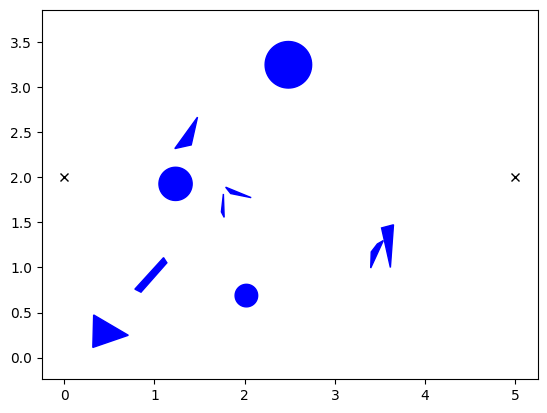

In [10]:
if __name__ == '__main__':

    M = Map((0, 2, 0), (5, 2, np.pi), (4, 4), 10, 5)
    
    pickle_filename = 'Map_i0_o10.pkl'
    
    with open(pickle_filename, 'wb') as file:
        pkl.dump(M, file)

    print(M.ObstacleList)

    M.plot()